### Задание:

Возьмите набор примеров fashion-MNIST. Опишите - какой результат нейросети получен в зависимости от числа нейронов в слое (для 2-х слойной сети),числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых параметров), проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей. Метрика - accuracy.

_____

импортируем библиотеки и модули:

In [1]:
import tensorflow as tf
import keras

from keras import optimizers
from keras.datasets import fashion_mnist
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RANDON_STATE = 0

вот данные и их размер:

In [2]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()
print(X_train.shape, X_test.shape)
print(y_train_labels.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)
(60000,)


Label is 5


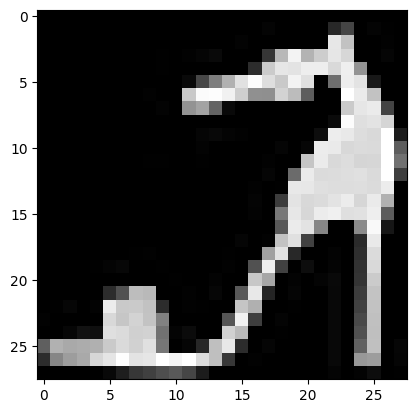

In [3]:
ind = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[ind], cmap='gray')
print(f'Label is {y_train_labels[ind]}')

In [4]:
X_train.min(), X_train.max()

(0, 255)

нормируем признаки и вытянем их в вектора:

In [5]:
# Нормировка
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.min(), X_train.max()

(0.0, 1.0)

In [6]:
# Вытягивание признаков
X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28 * 28))

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

проверим количество значений в таргете, должно быть 10:

In [7]:
set(y_test_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

из таргета с помощью OHE-кодирования сделаем матрицу:

In [8]:
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
def train_and_collect_metrics(X_train, y_train, X_test, y_test, num_epochs=4, batch_size=32,
                              number_of_neurons=[256, 128, 64, 32, 10],
                              number_of_layers=[2, 3, 5, 10, 15],
                              random_state=1, verbose=0):

    def get_plot(X, y, title, bar=False):
        """отрисовка графика изменения точности в зависимости от нейронов или слоёв"""

        plt.figure(figsize=(12, 5))
        if bar:
            plt.bar(X, y, color='#96C2DF', ec='#196F3D', width=.4)
        else:
            plt.plot(X, y, marker='x', color='#358B41')
        plt.xlabel(title)
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs {title}', fontsize=16, fontweight='bold')
        plt.minorticks_on()
        plt.grid(which='major', linewidth=.5)
        plt.grid(which='minor', linewidth=.25, linestyle='--');

    best_accuracy, best_model = 0.0, None
    accuracy_by_neurons, accuracy_by_layers = [], []

    for num_neurons in number_of_neurons:
        # создаем модель с фиксированным числом нейронов
        model_neurons = Sequential()
        model_neurons.add(Dense(num_neurons, input_shape=(28 * 28,), activation='relu'))
        model_neurons.add(Dense(10, activation='sigmoid'))

        # компилируем модель
        model_neurons.compile(
            optimizer=keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

        # учимся
        history_neurons = model_neurons.fit(X_train, y_train,
                                            epochs=num_epochs,
                                            batch_size=batch_size,
                                            validation_data=(X_test, y_test),
                                            verbose=verbose)
        # считаем accuracy
        _, accuracy = model_neurons.evaluate(X_test, y_test, verbose=verbose)
        # сохраняем лучшую модель
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model_neurons

        accuracy_by_neurons.append(accuracy)

    for num_layers in number_of_layers:
        # создаем модель с фиксированным числом слоев
        model_layers = Sequential()
        model_layers.add(Dense(best_model.layers[0].units, input_shape=(28 * 28,), activation='relu'))
        for _ in range(num_layers - 1):
            model_layers.add(Dense(best_model.layers[0].units, activation='relu'))
        model_layers.add(Dense(10, activation='sigmoid'))

        # компилируем модель
        model_layers.compile(
            optimizer=keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

        # учимся
        history_layers = model_layers.fit(X_train, y_train,
                                          epochs=num_epochs,
                                          batch_size=batch_size,
                                          validation_data=(X_test, y_test),
                                          verbose=verbose)
        # считаем метрики
        train_loss, train_accuracy = model_layers.evaluate(X_train, y_train, verbose=0)
        val_loss, val_accuracy = model_layers.evaluate(X_test, y_test, verbose=0)

        accuracy_by_layers.append(val_accuracy)

    get_plot(number_of_neurons, accuracy_by_neurons, 'Количество нейронов')
    get_plot(number_of_layers, accuracy_by_layers, 'Количество слоёв')

    # рассмотрим разные оптимизаторы
    optimizers = [keras.optimizers.SGD(), keras.optimizers.Adagrad(),
                  keras.optimizers.RMSprop(), keras.optimizers.Adam()]
    accuracy_by_optimizers = []

    for optimizer in optimizers:
        model_optimizer = Sequential()
        model_optimizer.add(Dense(best_model.layers[0].units, input_shape=(28 * 28,), activation='relu'))
        for _ in range(num_layers - 1):
            model_optimizer.add(Dense(best_model.layers[0].units, activation='relu'))
        model_optimizer.add(Dense(10, activation='sigmoid'))

        model_optimizer.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

        history_optimizer = model_optimizer.fit(X_train, y_train,
                                                epochs=num_epochs,
                                                batch_size=batch_size,
                                                validation_data=(X_test, y_test),
                                                verbose=verbose)

        _, accuracy = model_optimizer.evaluate(X_test, y_test, verbose=0)
        accuracy_by_optimizers.append(accuracy)

    get_plot([optimizer.__class__.__name__ for optimizer in optimizers],
             accuracy_by_optimizers, 'Оптимизатор', bar=True)

    return accuracy_by_optimizers

CPU times: user 36min 14s, sys: 2min 27s, total: 38min 41s
Wall time: 40min 37s


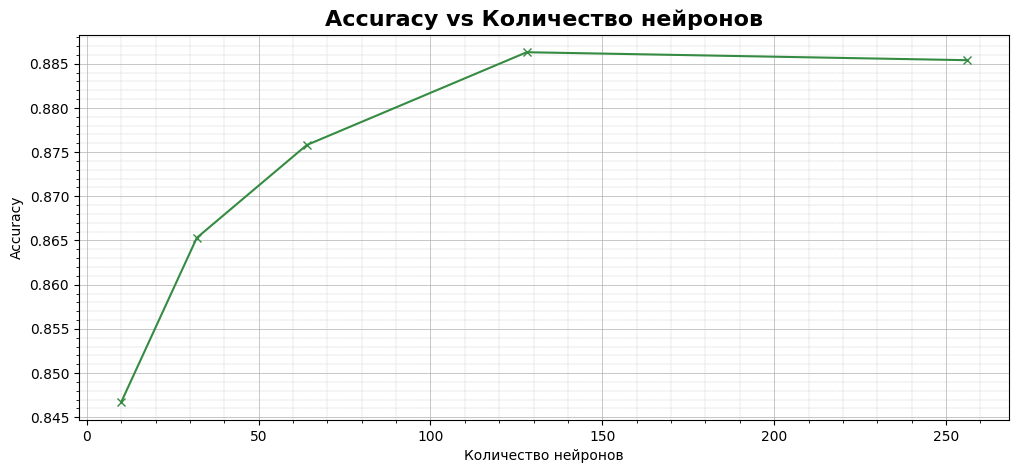

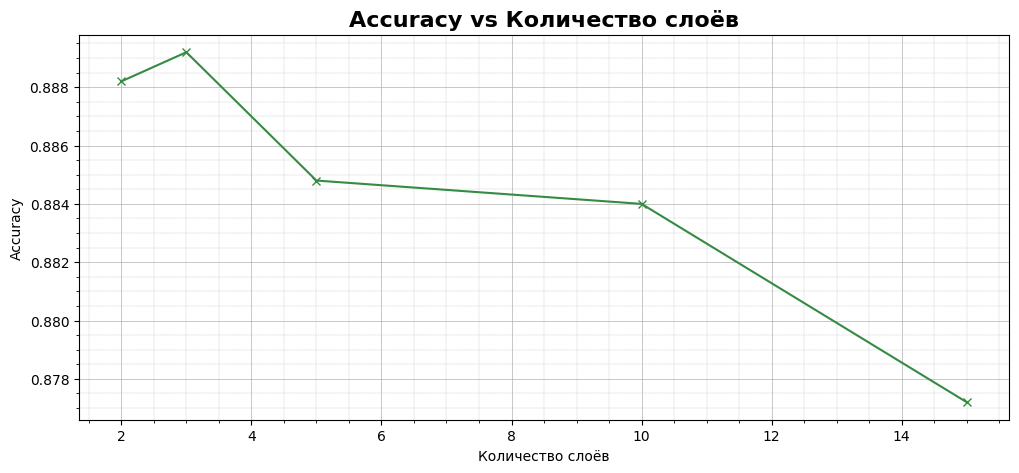

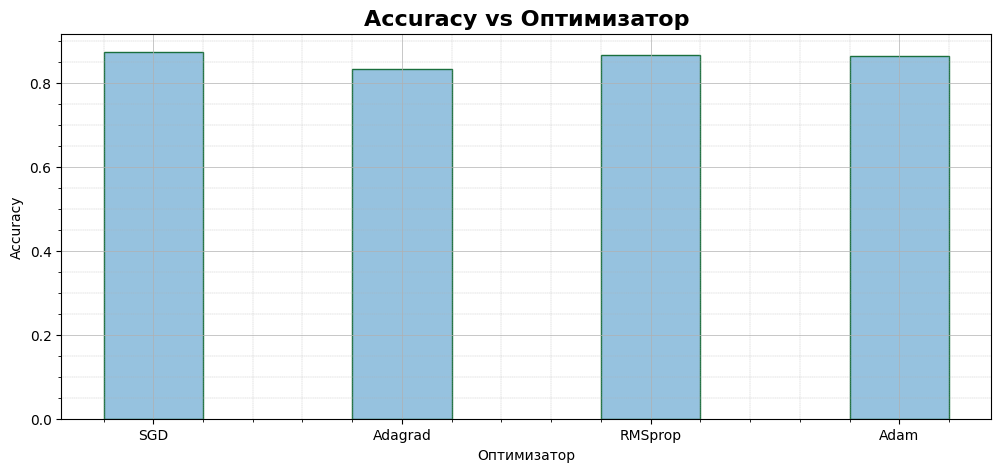

In [10]:
%%time
metrics_df = train_and_collect_metrics(X_train, y_train, X_test, y_test, num_epochs=20)

в конкретной задаче увеличение количества нейронов помогает получить более точную модель, а вот увеличение количества слоёв портит картинку, на 3-х можно остановиться. Оптимизаторы показывают плюс-минус одинаковый результат, но на самом деле с усложнением модели лучше всего справился бы Adam